In [2]:
%load_ext autoreload
%autoreload 2

## Super resolution

In [3]:
import fastai
from fastai.vision import *
from fastai.callbacks import *
from torchvision.models import vgg16_bn
torch.cuda.is_available()

True

In [4]:
pipeline = 'tensor_pipeline'

In [5]:
path = Path(f'./data/crappified/dataset_1/{pipeline}')
if pipeline == 'tensor_pipeline':
    path_hr = path/'orig_tensor'
    path_lr = path/'crap_tensor'
if pipeline == 'image_pipeline':
    path_hr = path/'orig_tensor'
    path_lr = path/'crap_tensor'

In [6]:
if pipeline == 'tensor_pipeline':
    meta = pd.read_csv('./data/crappified/dataset_1/meta/meta_tensor.csv')
if pipeline == 'image_pipeline':
    meta = pd.read_csv('./data/crappified/dataset_1/meta/meta_spectr.csv')
meta.subset = meta.subset == 'valid'

In [7]:
bs,size=16,128
arch = models.resnet34

if pipeline == 'tensor_pipeline':
    from crystal_clear.tensor_pipeline import TensorImageImageList, TensorImageList
    src = TensorImageImageList.from_df(meta, path_lr).split_from_df('subset')
    data_stats = torch.load('./data/crappified/dataset_1/tensor_pipeline/data_stats.pkl')
    def get_data(bs,size):
        data = (src.label_from_func(lambda x: path_hr/os.path.basename(x), label_cls=TensorImageList)
               .databunch(bs=bs).normalize(data_stats, do_y=True))
        data.c = 3
        return data

if pipeline == 'image_pipeline':
    from fastai.vision.data import imagenet_stats
    src = ImageImageList.from_df(meta, path_lr).split_from_df('subset')
    def get_data(bs,size):
        data = (src.label_from_func(lambda x: path_hr/os.path.basename(x), label_cls=ImageList)
               .databunch(bs=bs).normalize(imagenet_stats, do_y=True))
        data.c = 3
        return data

In [8]:
data = get_data(bs,size)

## Feature loss

In [13]:
t = data.valid_ds[0][1].data
t = torch.stack([t,t])

In [14]:
def gram_matrix(x):
    n,c,h,w = x.size()
    x = x.view(n, c, -1)
    return (x @ x.transpose(1,2))/(c*h*w)

In [15]:
gram_matrix(t)

tensor([[[ 96705.5234,    127.1368,   -456.7870],
         [   127.1368,  10844.0527,    443.7582],
         [  -456.7870,    443.7582, 107549.2500]],

        [[ 96705.5234,    127.1368,   -456.7870],
         [   127.1368,  10844.0527,    443.7582],
         [  -456.7870,    443.7582, 107549.2500]]])

In [16]:
base_loss = F.l1_loss

In [17]:
vgg_m = vgg16_bn(True).features
model_clas_name = 'model_2_fastai'
new_weights = torch.load(path / f'/{pipeline}/model_clas/{model_clas_name}_weights.pth')
vgg_m.load_state_dict(new_weights, strict= False)
vgg_m.cuda().eval()
requires_grad(vgg_m, False)

In [18]:
blocks = [i-1 for i,o in enumerate(children(vgg_m)) if isinstance(o,nn.MaxPool2d)]
blocks, [vgg_m[i] for i in blocks]

([5, 12, 22, 32, 42],
 [ReLU(inplace), ReLU(inplace), ReLU(inplace), ReLU(inplace), ReLU(inplace)])

In [19]:
class FeatureLoss(nn.Module):
    def __init__(self, m_feat, layer_ids, layer_wgts):
        super().__init__()
        self.m_feat = m_feat
        self.loss_features = [self.m_feat[i] for i in layer_ids]
        self.hooks = hook_outputs(self.loss_features, detach=False)
        self.wgts = layer_wgts
        self.metric_names = ['pixel',] + [f'feat_{i}' for i in range(len(layer_ids))
              ] + [f'gram_{i}' for i in range(len(layer_ids))]

    def make_features(self, x, clone=False):
        self.m_feat(x)
        return [(o.clone() if clone else o) for o in self.hooks.stored]
    
    def forward(self, input, target):
        out_feat = self.make_features(target, clone=True)
        in_feat = self.make_features(input)
        self.feat_losses = [base_loss(input,target)]
        self.feat_losses += [base_loss(f_in, f_out)*w
                             for f_in, f_out, w in zip(in_feat, out_feat, self.wgts)]
        self.feat_losses += [base_loss(gram_matrix(f_in), gram_matrix(f_out))*w**2 * 5e3
                             for f_in, f_out, w in zip(in_feat, out_feat, self.wgts)]
        self.metrics = dict(zip(self.metric_names, self.feat_losses))
        return sum(self.feat_losses)
    
    def __del__(self): self.hooks.remove()

In [20]:
feat_loss = FeatureLoss(vgg_m, blocks[2:5], [5,15,2])

## Train

In [21]:
wd = 1e-3
learn = unet_learner(data, arch, wd=wd, loss_func=feat_loss, callback_fns=LossMetrics,
                     blur=True, norm_type=NormType.Weight, path = path / f'{pipeline}')
gc.collect();

In [22]:
#learn.lr_find()
#learn.recorder.plot()

In [23]:
lr = 1e-3

In [24]:
def do_fit(save_name, lrs=slice(lr), pct_start=0.9):
    learn.fit_one_cycle(3, lrs)
    learn.save(save_name)
    learn.show_results(rows=1, imgsize=5)

In [ ]:
learn = learn.load('1a_tensor')

epoch,train_loss,valid_loss,pixel,feat_0,feat_1,feat_2,gram_0,gram_1,gram_2,time
0,1.209523,1.203201,0.085137,0.112935,0.133524,0.024922,0.252966,0.546707,0.047009,9:01:55
1,1.158904,1.176754,0.085712,0.112129,0.130325,0.024398,0.245810,0.532409,0.045971,9:00:56
2,1.153406,1.166248,0.085032,0.111521,0.129613,0.024207,0.243109,0.527197,0.045566,9:01:01


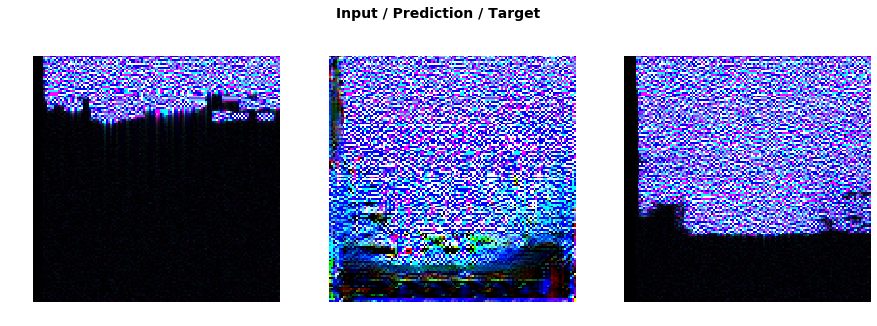

In [25]:
do_fit('1b_tensor')

In [32]:
learn.export('./models_export/1a_tensor.pkl')

/home/ludovic/miniconda3/envs/crystal_clear/lib/python3.6/site-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type FeatureLoss. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [26]:
learn.unfreeze()

In [22]:
#learn.lr_find()
#learn.recorder.plot()

In [25]:
lr = 1e-3

In [1]:
do_fit('1b', slice(1e-5,lr))

In [30]:
learn.export("./models_export/1b.pkl")

/home/ludovic/miniconda3/envs/crystal_clear/lib/python3.6/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type FeatureLoss. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
